Replicate Falkor data analysis for intermediate waters from Evans et al. 2020, and demonstrate improvements from using PYOMPA's hard mass conservation constraint.  

Reference for Evans et al: https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.1002/lno.11412

Install pyompa and gsw

In [1]:
!pip install pyompa

Download the input data (this was provided by Natalya Evans)

In [128]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import gsw

In [129]:
inp_data = pd.read_csv("/Users/annaliesemeyer/Documents/Jupyter Notebooks/OMPA/OMPA_input_CliOMZ.csv")

Load the input data

In [130]:
#Prepare a data frame for the Falkor data

inp_data['pressure'] = gsw.conversions.p_from_z(-inp_data["depth"].to_numpy(), inp_data['lat'].to_numpy(), geo_strf_dyn_height=0, sea_surface_geopotential=0)

inp_data['absolute_salinity'] = gsw.conversions.SA_from_SP(inp_data['sal'].to_numpy(),inp_data['pressure'].to_numpy(), inp_data['lon'].to_numpy(),inp_data['lat'].to_numpy())

inp_data['conservative_temp'] = gsw.conversions.pt0_from_t(inp_data['absolute_salinity'].to_numpy(), inp_data['temp'].to_numpy(), inp_data["pressure"].to_numpy())

inp_data['pdens'] = gsw.density.sigma0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

inp_data['spiciness'] = gsw.spiciness0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

falkor_df = inp_data

#If we were using the hard mass conservation constraint, it would not be
# necessary to specify this "mass" variable; however, to replicate the MATLAB
# OMP analysis, we have to create a separate variable for mass
falkor_df["mass"] = 1.0

#Filter the data frame to density ranges used for intermedite waters
intermediatewaters_falkordf = pd.DataFrame(
    falkor_df[(falkor_df["pdens"] >= 25.0)
              & (falkor_df["pdens"] <= 27.5)])

Define the end-members

In [131]:
#                                   temp       sal         oxy     PO4       Si     
CW13_FK =        ["13CW_FK",       12.54,    34.98,       0.59,   2.73,    29.8]
NEPIW_FK =       ["NEPIW_FK",       9.56,    33.80,       0.64,   3.1,    50]
AAIW =           ["AAIW",           5.5,    34.3,       238,    1.97,   24.6]
STSW =           ["STSW",           22,    36.0,       220,    0.2,   0.5]
PDW =            ["PDW",           1.8,    34.7,       105,    2.76,   157.3]

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "silicate"])
    df["mass"] = 1
    return df

intermediatewaters_FK_endmemberdf = prepare_endmember_df(
    [CW13_FK, NEPIW_FK, AAIW, STSW, PDW])


Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [132]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc 
#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
        always_positive=False #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]
usage_penalty = {
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

settings = {
    "param_names": ["conservative_temp", "absolute_salinity",
                    "oxygen", "mass", "phosphate"],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False
}


ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")
#Run the analysis, replicating the MATLAB OMP analysis
#orig_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
#  obs_df = intermediatewaters_falkordf,
#  **evansorig_settings).solve(
#      intermediatewaters_FK_endmemberdf,
#      endmember_name_column="endmember_name")

Dropping 1 rows that have NA values in the observations
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict({'13CW': [0], 'NEPIW': [1], 'AAIW': [2], 'STSW': [3], 'PDW': [4]})
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'mass', 'phosphate']
param weighting: [24. 24.  7. 24.  2.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 198 out of 198
status: optimal
optimal value 4190.9178747034475
Original weighted sum squares: 4185.901629343185
Post fix weighted sum squared: 4185.901629338859
Trying convertedvariable sign constraint: [-1]
On example 0 to 198 out of 198
status: optimal
optimal value 293759.100740156
Original weighted sum squares: 293759.0709069594
Post fix weighted sum squared: 293759.0709105575
On example 0 to 198 out of 198
status: optimal
optimal value 1148.1028925473636
Original weighted sum squares: 1148.0729411153307
Post fix weighted sum squared: 1148.072941118115
objective: 1148.0729411181148


Display the results that replicate the original MATLAB OMP analysis - note the large salinity residuals (up to 6; these occur at locations that likely suffer from a missing end-member), and how the large salinity residuals line up with the residuals in mass conservation.

eOMP - Nuts


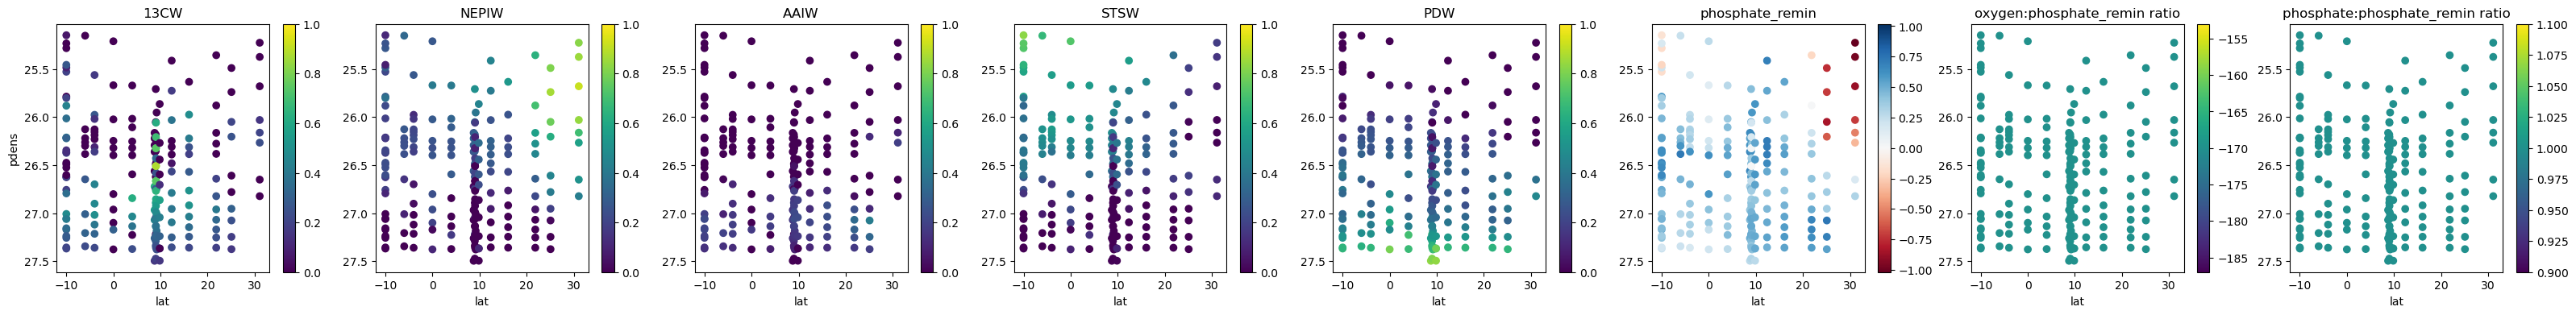

eOMP - Nuts: Residuals


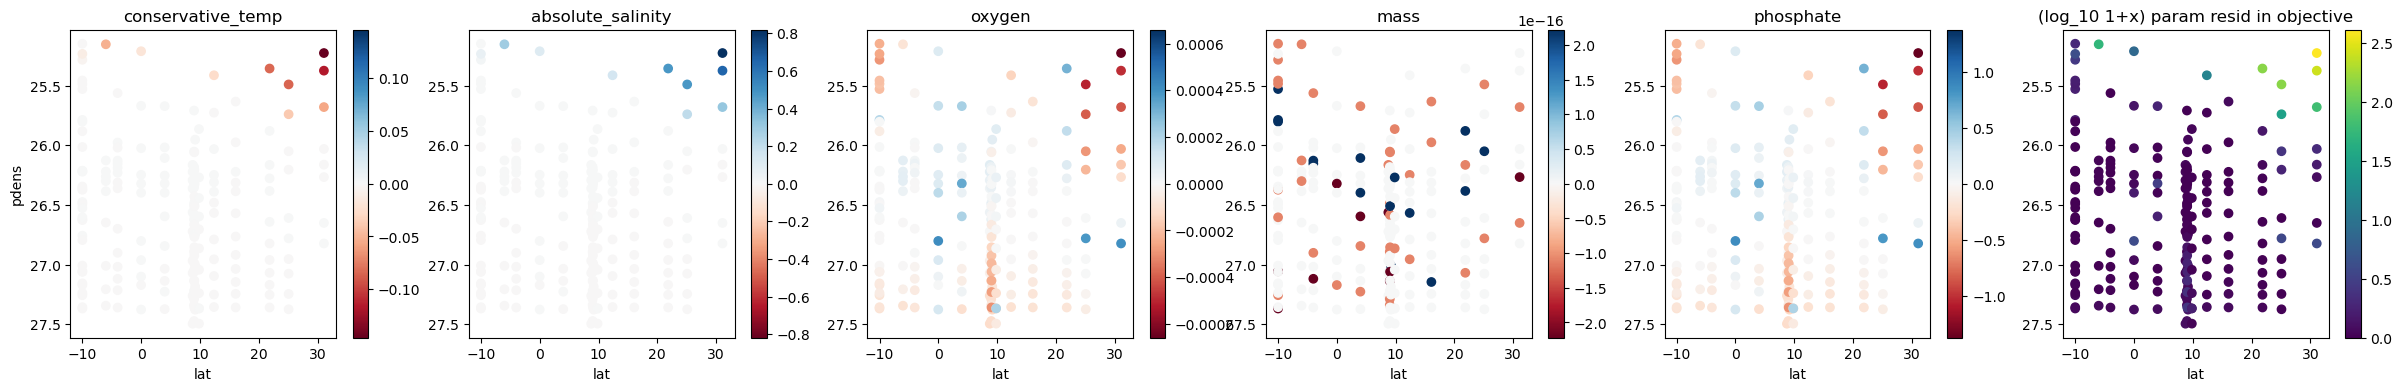

In [133]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("eOMP - Nuts")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname="lat",
                                  yaxis_colname=yaxis_colname)
print("eOMP - Nuts: Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname="lat",
                        yaxis_colname=yaxis_colname)


Also verify that the results are numerically equivalent to the results provided by the authors

In [134]:
inp_data = pd.read_csv('/Users/annaliesemeyer/Documents/Jupyter Notebooks/OMPA/OMPA_input_CliOMZ_NoNuts.csv')

Do a new analysis, this time imposing a hard constraint on mass conservation

In [135]:
inp_data['pressure'] = gsw.conversions.p_from_z(-inp_data["depth"].to_numpy(), inp_data['lat'].to_numpy(), geo_strf_dyn_height=0, sea_surface_geopotential=0)

inp_data['absolute_salinity'] = gsw.conversions.SA_from_SP(inp_data['sal'].to_numpy(),inp_data['pressure'].to_numpy(), inp_data['lon'].to_numpy(),inp_data['lat'].to_numpy())

inp_data['conservative_temp'] = gsw.conversions.pt0_from_t(inp_data['absolute_salinity'].to_numpy(), inp_data['temp'].to_numpy(), inp_data["pressure"].to_numpy())

inp_data['pdens'] = gsw.density.sigma0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

inp_data['spiciness'] = gsw.spiciness0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

falkor_df = inp_data

#If we were using the hard mass conservation constraint, it would not be
# necessary to specify this "mass" variable; however, to replicate the MATLAB
# OMP analysis, we have to create a separate variable for mass
falkor_df["mass"] = 1.0

#Filter the data frame to density ranges used for intermedite waters
intermediatewaters_falkordf = pd.DataFrame(
    falkor_df[(falkor_df["pdens"] >= 25.0)
              & (falkor_df["pdens"] <= 27.5)])

In [136]:
#                                   temp       sal         oxy     PO4       Si     
CW13_FK =        ["13CW_FK",       12.54,    34.98,       0.59,   2.73,    29.8]
NEPIW_FK =       ["NEPIW_FK",       9.56,    33.80,       0.64,   3.1,    50]
AAIW =           ["AAIW",           5.5,    34.3,       238,    1.97,   24.6]
STSW =           ["STSW",           22,    36.0,       220,    0.2,   0.5]
PDW =            ["PDW",           1.8,    34.7,       105,    2.76,   157.3]

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "silicate"])
    df["mass"] = 1
    return df

intermediatewaters_FK_endmemberdf = prepare_endmember_df(
    [CW13_FK, NEPIW_FK, AAIW, STSW, PDW])

In [137]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc 
#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
        always_positive=False #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]
usage_penalty = {
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "mass": 24.0,
    "oxygen": 7.0,
}

settings = {
    "param_names": ["conservative_temp", "absolute_salinity",
                    "oxygen", "mass"],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False
}


ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")
#Run the analysis, replicating the MATLAB OMP analysis
#orig_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
#  obs_df = intermediatewaters_falkordf,
#  **evansorig_settings).solve(
#      intermediatewaters_FK_endmemberdf,
#      endmember_name_column="endmember_name")

Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict({'13CW': [0], 'NEPIW': [1], 'AAIW': [2], 'STSW': [3], 'PDW': [4]})
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'mass']
param weighting: [24. 24.  7. 24.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 56120 out of 56120
status: optimal
optimal value 184466.62597568863
Original weighted sum squares: 184264.10873619147
Post fix weighted sum squared: 184264.11638490565
Trying convertedvariable sign constraint: [-1]
On example 0 to 56120 out of 56120
status: optimal
optimal value 115590514.25273186
Original weighted sum squares: 115590514.24814332
Post fix weighted sum squared: 115590514.24923064
On example 0 to 56120 out of 56120
status: optimal
optimal value 63667.09746345764
Original weighted sum squares: 63667.08655808678
Post fix weighted sum squared: 63667.08655807658
objective: 63667.08655807658


OMP - CTD data


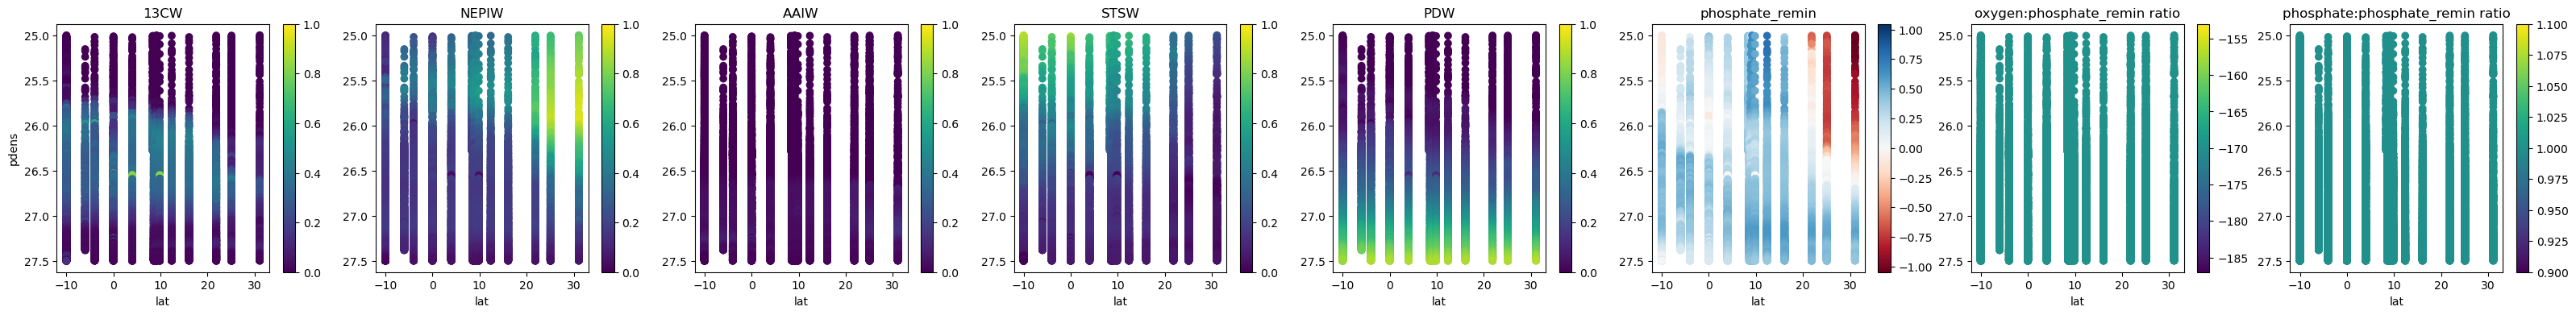

OMP - CTD data: Residuals


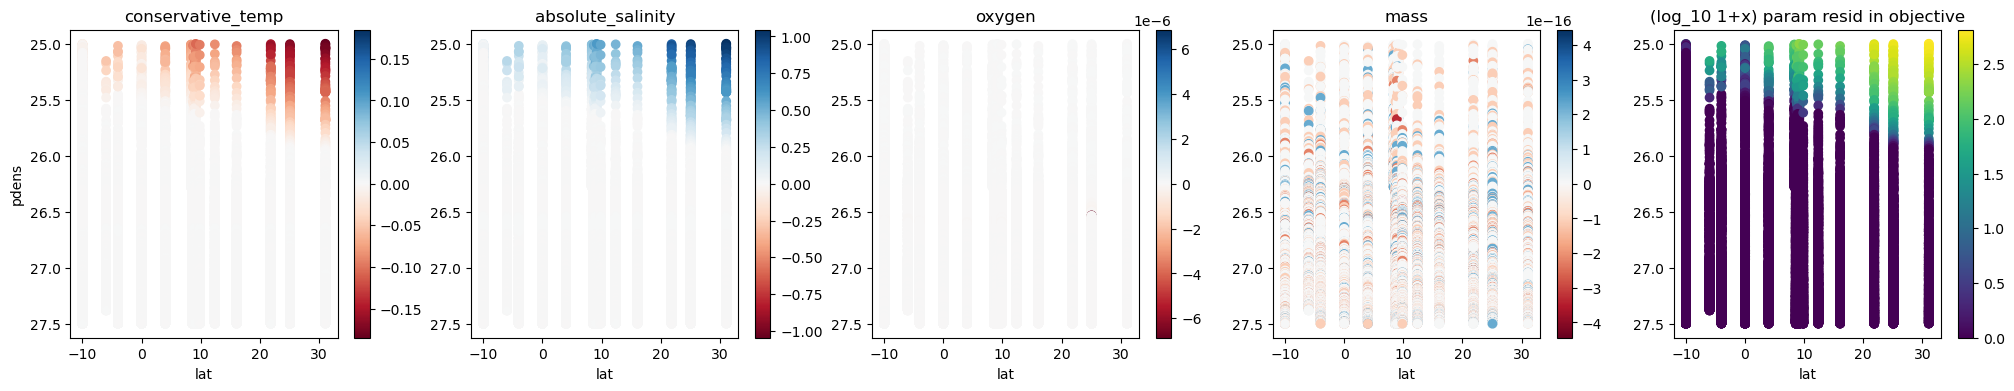

In [138]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("OMP - CTD data")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname="lat",
                                  yaxis_colname=yaxis_colname)
print("OMP - CTD data: Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname="lat",
                        yaxis_colname=yaxis_colname)

######











# -
#####

In [82]:
hardmasscons_settings = {
    "param_names": ["conservative_temp", "absolute_salinity",
                    "oxygen", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    #The difference here is that sumtooneconstraint is True
    "sumtooneconstraint": True,
    "standardize_by_watertypes": False
}

#Run the analysis with the hard mass conservation constraint
hardmasscons_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **hardmasscons_settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Endmember-idx mapping is
 OrderedDict({'13CW': [0], 'NEPIW': [1], 'AAIW': [2], 'STSW': [3], 'PDW': [4]})
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'mass']
param weighting: [24. 24.  7. 24.]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 93034 out of 93034
status: optimal
optimal value 5709816.791773151
Original weighted sum squares: 5709816.791773151
Post fix weighted sum squared: 5709817.0954167945
On example 0 to 93034 out of 93034
status: optimal
optimal value 5709816.791773151
Original weighted sum squares: 5709816.791773151
Post fix weighted sum squared: 5709817.0954167945
objective: 5709817.095416794


Display the results with the hard mass conservation cosntraint; note the improvement in the salinity residuals (now on the order of 0.06)

Hard mass conservation - Water mass fractions and deltaP


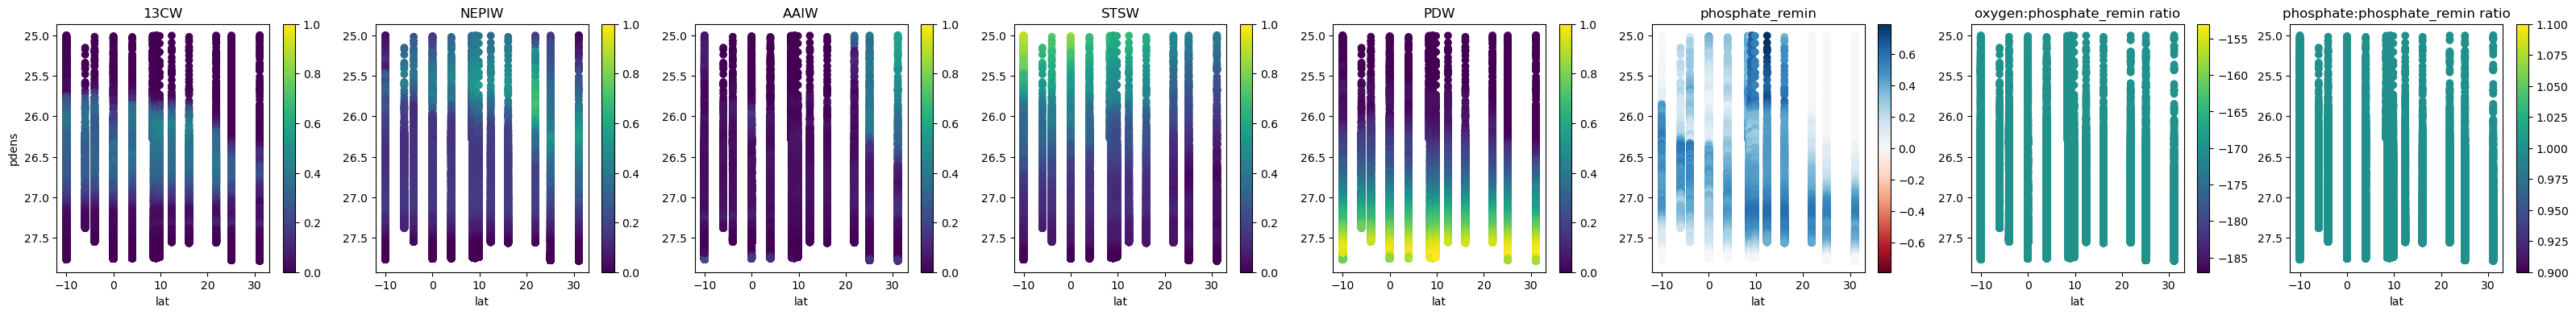

Hard mass conservation - Residuals


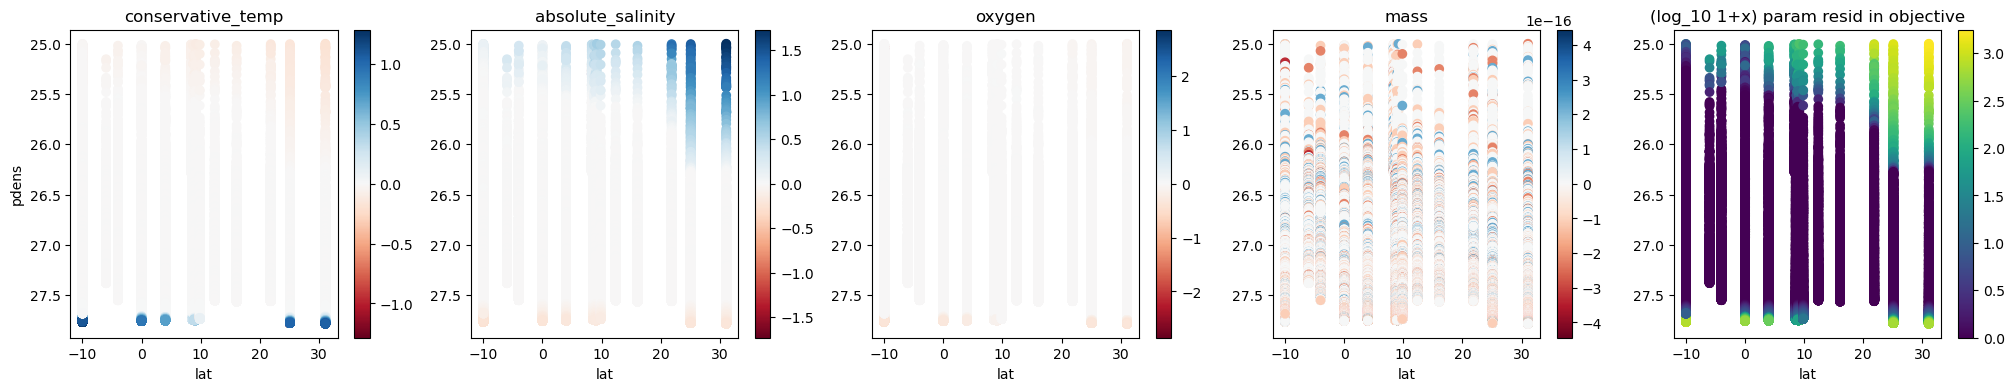

In [83]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("Hard mass conservation - Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(
    ompa_soln=hardmasscons_intermediate_falkordf_ompasoln,
    xaxis_colname="lat",
    yaxis_colname=yaxis_colname)
print("Hard mass conservation - Residuals")
plot_ompasoln_residuals(ompa_soln=hardmasscons_intermediate_falkordf_ompasoln,
                        xaxis_colname="lat",
                        yaxis_colname=yaxis_colname)

Export to CSV

In [41]:
hardmasscons_intermediate_falkordf_ompasoln.export_to_csv(
    csv_output_name="pyompa_output.csv",
    orig_cols_to_include=["lat", "lon", "pdens","depth"] #any other columns from the original data frame to include
)

writing to pyompa_output.csv


In [42]:
#preview the first ten lines of the csv as a sanity check
!head pyompa_output.csv

lat,lon,pdens,depth,conservative_temp,absolute_salinity,oxygen,mass,conservative_temp_resid,absolute_salinity_resid,oxygen_resid,mass_resid,13CW_frac_total,NEPIW_frac_total,AAIW_frac_total,STSW_frac_total,PDW_frac_total,13CW_FK_frac,NEPIW_FK_frac,AAIW_frac,STSW_frac,PDW_frac,phosphate_remin,oxygen_to_phosphate_remin_ratio,phosphate_to_phosphate_remin_ratio
8.75242,-88.97092,25.261154166805227,50.288,17.038087355112264,34.840509067222186,92.515,1.0,-0.04835589050569311,0.2734305808593689,-9.947598300641403e-14,0.0,1.191254804168376e-15,0.4027547054174773,1.0872711906769764e-16,0.5972452945825215,0.0,1.191254804168376e-15,0.4027547054174773,1.0872711906769764e-16,0.5972452945825215,0.0,0.2302160459977768,-170.0,1.0
8.7524,-88.97092,25.398557520506074,51.294,16.486513786341124,34.85087252135356,75.559,1.0,-0.029851119101824253,0.16879450983023503,-1.4210854715202004e-13,-1.1102230246251565e-16,0.0,0.4456058949164545,2.0680121508589702e-16,0.5543941050835451,0.0,0.0,0.4456058949164545,2.06

In [122]:
inp_data = pd.read_csv('/Users/annaliesemeyer/Documents/Jupyter Notebooks/OMPA/OMPA_input_CliOMZ_NoNuts.csv')

In [123]:
#Prepare a data frame for the Falkor data

inp_data['pressure'] = gsw.conversions.p_from_z(-inp_data["depth"].to_numpy(), inp_data['lat'].to_numpy(), geo_strf_dyn_height=0, sea_surface_geopotential=0)

inp_data['absolute_salinity'] = gsw.conversions.SA_from_SP(inp_data['sal'].to_numpy(),inp_data['pressure'].to_numpy(), inp_data['lon'].to_numpy(),inp_data['lat'].to_numpy())

inp_data['conservative_temp'] = gsw.conversions.pt0_from_t(inp_data['absolute_salinity'].to_numpy(), inp_data['temp'].to_numpy(), inp_data["pressure"].to_numpy())

inp_data['pdens'] = gsw.density.sigma0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

inp_data['spiciness'] = gsw.spiciness0(inp_data['absolute_salinity'].to_numpy(), inp_data['conservative_temp'].to_numpy())

falkor_df = inp_data

#If we were using the hard mass conservation constraint, it would not be
# necessary to specify this "mass" variable; however, to replicate the MATLAB
# OMP analysis, we have to create a separate variable for mass
falkor_df["mass"] = 1.0

#Filter the data frame to density ranges used for intermedite waters
intermediatewaters_falkordf = pd.DataFrame(
    falkor_df[(falkor_df["pdens"] >= 25.0)
              & (falkor_df["pdens"] <= 28.0)])



In [124]:
#                                   temp       sal          
CW13_FK =        ["13CW_FK",       12.54,    34.98]
NEPIW_FK =       ["NEPIW_FK",       9.56,    34.80]
ESW =           ["ESW",           23.28,    34.56]
UCDW =           ["UCDW",           1.42,    34.87]
AAIW =           ["AAIW",           5.5,    34.3]
STSW =           ["STSW",           22,    36.0]
PDW =           ["PDW",           1.8,    34.7]





def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity"])
    return df

working_endmemberdf = prepare_endmember_df(
    [CW13_FK, NEPIW_FK, AAIW,ESW,UCDW,STSW,PDW])

In [59]:
import pyompa

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
}

evansorig_settings = {
    "param_names": ["conservative_temp", "absolute_salinity"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": [],
    "sumtooneconstraint": True,
    "standardize_by_watertypes": False
}

#Run the analysis, replicating the MATLAB OMP analysis
orig_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **evansorig_settings).solve(
      working_endmemberdf,
      endmember_name_column="endmember_name")

Endmember-idx mapping is
 OrderedDict({'13CW': [0], 'NEPIW': [1], 'AAIW': [2], 'ESW': [3], 'UCDW': [4], 'STSW': [5], 'PDW': [6]})
params to use: ['conservative_temp', 'absolute_salinity']
param weighting: [24. 24.]
Matrix A:
On example 0 to 93034 out of 93034
status: optimal
optimal value 89032.46927995874
Original weighted sum squares: 89032.46927995874
Post fix weighted sum squared: 89032.48744656517
objective: 89032.48744656515


Water mass fractions


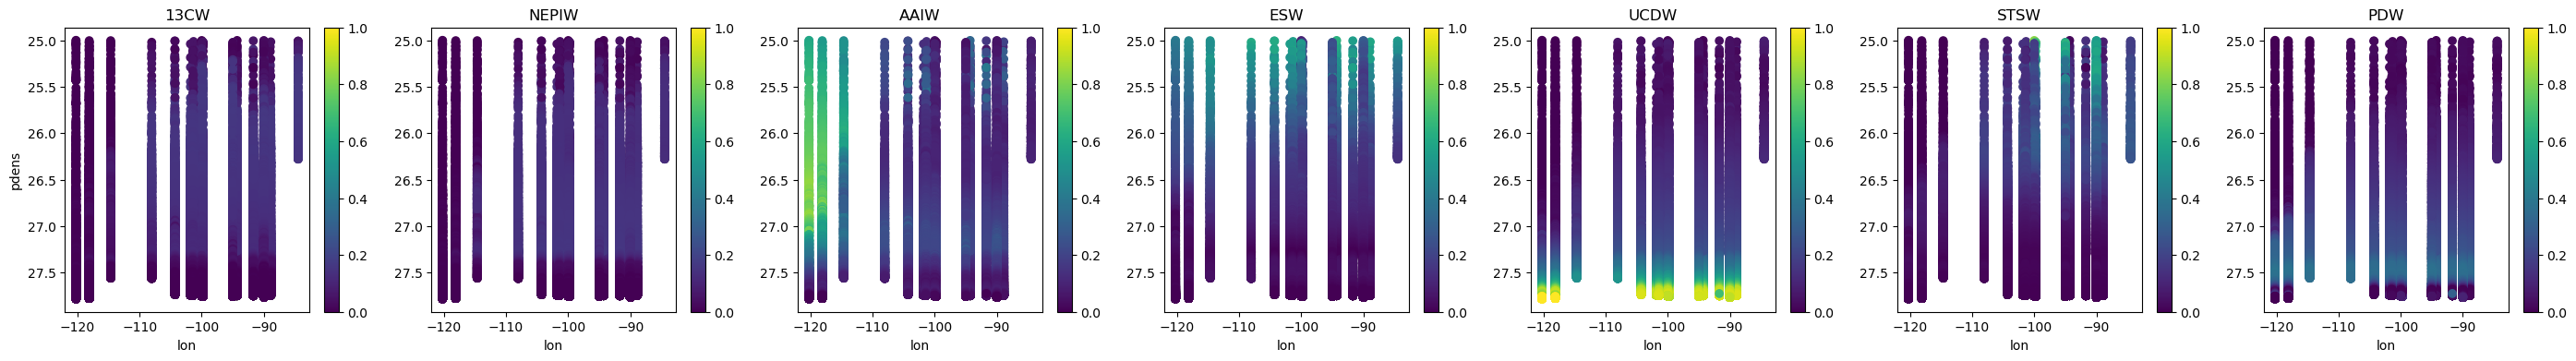

Residuals


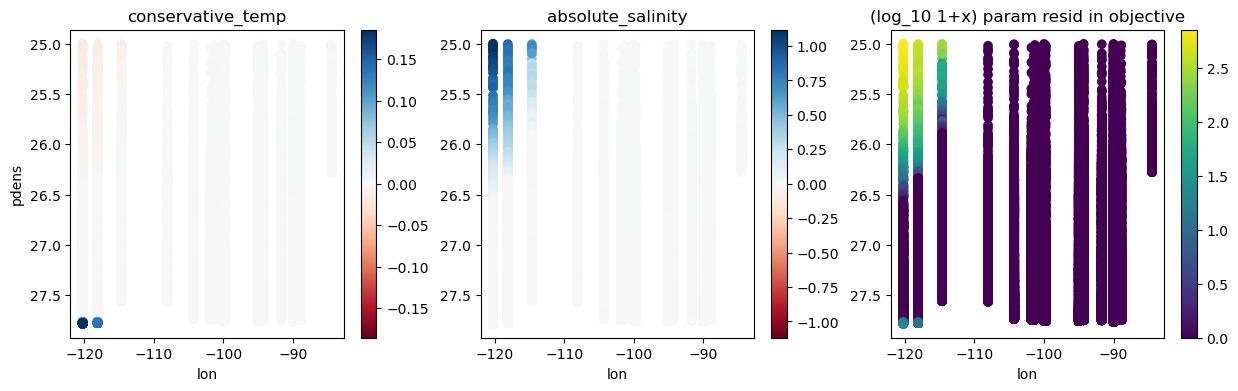

In [62]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,
                    plot_ompasoln_residuals,
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("Water mass fractions")
plot_ompasoln_endmember_fractions(ompa_soln=orig_intermediate_falkordf_ompasoln,
                                  xaxis_colname="lon",
                                  yaxis_colname=yaxis_colname)
print("Residuals")
plot_ompasoln_residuals(ompa_soln=orig_intermediate_falkordf_ompasoln,
                        xaxis_colname="lon",
                        yaxis_colname=yaxis_colname)

In [61]:
orig_intermediate_falkordf_ompasoln.export_to_csv(
    csv_output_name="pyompa_output_nonuts.csv",
    orig_cols_to_include=["lat", "lon", "pdens","depth"] #any other columns from the original data frame to include
)

writing to pyompa_output_nonuts.csv
